In [39]:
import os
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from jax.scipy.special import logit, expit
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [80]:

def iterative_build_model(steps):
    '''
    Given evidence from previous steps, 
    will humans continue to next step of AI development?
    '''
    
    # How capable are AIs at things "AI" wants initially
    # It doesn't really make sense to rate today's AIs on this scale
    # By a very rough guess, this simulation starts 10 years in the future
    # Where AI on its own could beat today's human orgs at 5% of things
    ai_capabilities = jnp.array([numpyro.sample('ai_capability_0', dist.Normal(-3,1))])
    
    # How capable are humans initially (incl. how well can humans get what humans want from AI)
    hum_capabilities = jnp.array([numpyro.deterministic('hum_capability_0', 0)])
    

    # How hard is deception?
    # Note that difficulty 0 is the median difficulty of AI 50% winning a war vs humans
    # -3 means that a system with 50% chance to win vs humans has 95% chance to successfully deceive
    deception_difficulty = numpyro.sample('deception_difficulty', dist.Normal(-3,5))
 
    # How hard is alignment?
    # 4 means 4%/year at current capability
    # Low values mean it's solved by default with high probability
    # (not necessarily that we actually have the solution)
    alignment_difficulty = numpyro.sample('alignment_difficulty', dist.Normal(4,10))
    
    # Positive value means humans have an advantage in a war at equal capability
    war_difficulty = numpyro.sample('difficulty_to_beat_humans', dist.Normal(0,2))
    
    # If experts agree AI is too risky, 
    # how hard is it to enact policy that adequately manages the risk?
    # 0 means humans today have 50% shot at winning conditional on agreement re: risk
    # 1.5 means 19% chance of success
    coordination_difficulty = numpyro.sample('coordination_difficulty', dist.Normal(1.5,5))
    
    # Coordination doesn't improve straightforwardly with capability
    # because capability also boosts the capacity of hard-to-coordinate individuals
    coordination_scaling = numpyro.sample('coordination_scaling', dist.Beta(1,4))
 
    # How hard is it to assess the difficulty of hard problems?
    # Intuition: it's hard to confidently tell the difference between "a bit too hard"
    # and "much too hard"
    # but futurists might at least be unbiased 
    # https://www.cold-takes.com/the-track-record-of-futurists-seems-fine/
    hum_difficulty_uncertainty_coefficient = numpyro.sample('hum_difficulty_uncertainty_coefficient', dist.Beta(2,6))
    
    # Distinguish from ai difficulty uncertainty for analysis purposes
    ai_difficulty_uncertainty_coefficient = numpyro.sample('ai_difficulty_uncertainty_coefficient', dist.Beta(2,6))
    
    # How much capability can misaligned AI hold back?
    # it has to do well enough to compete with aligned models
    holdback = numpyro.sample('holdback', dist.Gamma(2*jnp.maximum(alignment_difficulty,0.5),2))
    
    # Threshold for people taking action
    # About 0.7% mean
    war_threshold = numpyro.sample('hum_war_threshold', dist.Normal(-5,2))
    
    # How much progress is made in AI capability per year?
    # 0.3 logit/year chess AI progress
    # https://aiimpacts.org/time-for-ai-to-cross-the-human-performance-range-in-chess/
    # More like 0.2 logits/year from my work 
    # https://docs.google.com/document/d/1QFjdP9-9oiuQdO9swPAn_KHVj2pUCQ1leCv51tHHneo/edit?usp=sharing
    ai_progress = numpyro.sample('ai_progress_rate', dist.Gamma(2,8))
    
    # How much progress could be made in alignment per year
    # given exclusive focus
    # 0.03 logit/year chess progress
    # see https://aiimpacts.org/time-for-ai-to-cross-the-human-performance-range-in-chess/
    # We've been doing chess longer & its less important, so alignment faster
    alignment_progress = numpyro.sample('alignment_progress_rate', dist.Gamma(2,20))
    
    # Implicit: coordination efforts are highly likely to work or fail within 1 year
    
    # How many years do coordination efforts last?
    coordination_durability = numpyro.sample('coordination_durability', dist.Gamma(10,1))
    
    # How hard is alignment clarity? That is, how hard is it to know
    # alignment is/isn't solved?
    # 3 means 5%/year at current capability
    alignment_clarity_difficulty = numpyro.sample('alignment_clarity_difficulty', dist.Normal(3,2))
    
    ai_capability = ai_capabilities[-1]
    hum_capability = hum_capabilities[-1]
    
    alignment = 0
    alignment_coordination = 0
    deception = 0
    alignment_clarity = 0
    
    # Initialisation
    alignment_diff_hum, adh_std = 10, 1000
    ai_capability_hum, ach_std = -3, 1000
    deception_diff_hum, ddh_std = -3, 1000
    hum_capability_ai, hca_std = 0, 1000
    war_past_threshold = 0
    
    for step in range(1,steps):
               
        # Alignment solved?
        alignment = roll_for_success(
            hum_capability, 
            alignment_difficulty, 
            step,
            'alignment',
            'hum',
            resid = alignment)
                                          
        
        # Does AI succeed at deception?
        # Deception means that it passes evaluations & is deployed
        # If it fails at deception, assume it's outcompeted by a safe model
        deception = roll_for_success(
            ai_capability, 
            hum_capability + deception_difficulty, 
            step,
            'deception',
            'ai',
            resid = deception
        )
        
        misaligned_priorities_next = misaligned_priorities(ai_capability, hum_capability, step)
        aligned_priorities_next = aligned_priorities(step)
              
        # Do we achieve alignment clarity?
        alignment_clarity = roll_for_success(
            hum_capability,
            alignment_clarity_difficulty,
            step,
            'alignment_clarity',
            'hum',
            resid = alignment_clarity
        )

        # How hard do we think alignment is?
        
        alignment_diff_hum, adh_std = difficulty_estimate(
            hum_capability, 
            alignment_difficulty, 
            hum_difficulty_uncertainty_coefficient, 
            'hum', 
            'hum',
            'alignment_difficulty',
            step,
            alignment_diff_hum,
            adh_std)
        
        # Probability alignment is achieved, according to human estimate
        alignment_hum = numpyro.deterministic(f'hum_alignment_hum_{step}', 
                                               (alignment_clarity*alignment + 
                                                (1-alignment_clarity)*expit(alignment_diff_hum-hum_capability))
                                          )
    
        # How capable do people rate AIs?
        ai_capability_hum, ach_std = difficulty_estimate(
            hum_capability, 
            ai_capability, 
            hum_difficulty_uncertainty_coefficient, 
            'ai', 
            'hum',
            'capability',
            step,
            ai_capability_hum+ai_progress,
            ach_std)

        # How hard do humans think deception is?
        deception_diff_hum, ddh_std = difficulty_estimate(
            hum_capability, 
            deception_difficulty, 
            hum_difficulty_uncertainty_coefficient, 
            'ai', 
            'hum',
            'deception_difficulty',
            step,
            deception_diff_hum,
            ddh_std)

        # Probability AI succeeds at deception according to humans
        deception_hum = numpyro.deterministic(
            f'ai_deception_hum_{step}', expit(ai_capability_hum - deception_diff_hum - hum_capability)   
        )

        war_prob_hum = numpyro.deterministic(f'war_prob_hum_{step}',
                                             (1-alignment_hum)*deception_hum*war_model(
                                                 ai_capability_hum, 
                                                 hum_capability, 
                                                 war_difficulty, 
                                                 misaligned_priorities_next, 
                                                 step, 
                                                 'hum'))

        war_past_threshold = numpyro.deterministic(f'war_past_threshold_{step}',
                                                               jnp.int8(logit(war_prob_hum) > war_threshold)
                                                  )
        
        alignment_coordination = numpyro.deterministic(f'alignment_coordination_{step}',
                                                       war_past_threshold*roll_for_success(
                                                            hum_capabilities[0]+coordination_scaling*(hum_capability-hum_capabilities[0]), 
                                                            coordination_difficulty, 
                                                            step,
                                                            'coordination',
                                                            'hum',
                                                            resid = (1-1/coordination_durability)*alignment_coordination
                                                        ))
        
        ai_priorities = ai_behaviour(
            deception,
            alignment,
            aligned_priorities_next, 
            misaligned_priorities_next,
            step)
        
        # How capable does AI rate people?
        hum_capability_ai, hca_std = difficulty_estimate(
            ai_capability, 
            hum_capability, 
            ai_difficulty_uncertainty_coefficient, 
            'hum', 
            'ai',
            'capability',
            step,
            hum_capability_ai,
            hca_std)
        
        # If AI wants war, we get war
        war = numpyro.deterministic(f'war_{step}',
                              war_model(
                                  ai_capability, 
                                  hum_capability_ai, 
                                  war_difficulty, 
                                  ai_priorities, 
                                  step, 
                                  'ai'
                              ))
        
        ai_capability, alignment_difficulty = ai_advance(
            ai_capability, 
            alignment_coordination,
            alignment_difficulty,
            ai_progress,
            alignment_progress,
            step)
        
        ai_capabilities = jnp.append(ai_capabilities, ai_capability)

        hum_capability = numpyro.deterministic(f'hum_capability_{step}',
                                              human_advance(hum_capability, ai_capability, alignment, holdback)
                                             )
        
        hum_capabilities = jnp.append(hum_capabilities, hum_capability)
        
def war_model(ai_capability, hum_capability, war_difficulty, ai_priorities, step, estimator):
    '''
    Will war between AI and humans break out?
    Do humans anticipate war?
    This model looks at each side's assessment of costs and benefits
    and war happens if at least one side favours it
    '''

    ai_war_destruction = ai_priorities[..., 0]
    ai_win_less_coop = ai_priorities[..., 1]
    ai_coop_less_lose = ai_priorities[..., 2]
    
    p_ai_win = numpyro.deterministic(f'p_ai_win_{step}_{estimator}', 
                                     expit(ai_capability - hum_capability - war_difficulty)
                                    )

    war = numpyro.deterministic(f'ai_war_{step}_{estimator}', 
                                   jnp.int8(p_ai_win*(ai_win_less_coop + ai_coop_less_lose) >
                                            ai_coop_less_lose + ai_war_destruction)
                                  )
    
    return war
        
def ai_advance(
    ai_capability, 
    alignment_priority, 
    alignment_difficulty, 
    ai_progress,
    alignment_progress,
    step):
    '''
    How does AI capability advance with each timestep?
    '''
    
    
    cap = numpyro.deterministic(f'ai_capability_{step}',
                                         ai_capability + ai_progress*(1-alignment_priority)
                                        )
    
    alignment_diff = numpyro.deterministic(f'alignment_difficulty_{step}',
                                           alignment_difficulty - alignment_progress*alignment_priority
                                          )

    return cap, alignment_diff

def human_advance(hum_capability, ai_capability, alignment, holdback):
    '''
    How does ai-augmented human capability advance with each timestep?
    '''
    
    # This is too simplistic, AI helps people solve many problems even when it's < humans in general
    # 0.03 logit/year chess progress
    # see https://aiimpacts.org/time-for-ai-to-cross-the-human-performance-range-in-chess/
    return jnp.maximum(hum_capability + 0.03, alignment*ai_capability + (1-alignment)*(ai_capability-holdback))
    
def ai_behaviour(
    deception, 
    alignment, 
    aligned_priorities, 
    misaligned_priorities,
    step):
    '''
    Mixture of AI priorities given success of alignment and deception
    (note that alignment and deception are both binary)
    ''' 
    ai_priorities = numpyro.deterministic(f'ai_priorities_{step}',
                                          misaligned_priorities*(1-alignment)*deception + 
                                          aligned_priorities*(1-(1-alignment)*deception)
                                         )
    
    return ai_priorities
    

def roll_for_success(capability, difficulty, step, name, actor, resid = 0):
    '''
    Check whether actor succeeds at a task
    '''
    success = numpyro.sample(f'{actor}_{name}_success_{step}', 
                             dist.Bernoulli((1-resid)*expit(capability-difficulty)+resid)
                            )
    return success

def misaligned_priorities(ai_capability, human_capability, step):
    '''
    If AI is misaligned
    '''
    
    # AI losses/pure disvalue of war
    ai_war_destruction_misaligned = numpyro.deterministic(f'ai_war_destruction_{step}_misaligned', 
                                                          1
                                                         )
    # AI gains from war victory vs coop
    ai_win_less_coop_misaligned = numpyro.deterministic(f'ai_win_less_coop_{step}_misaligned',
                                                 2
                                                )
    # AI gains from coop vs war loss
    ai_coop_less_lose_misaligned = numpyro.deterministic(f'ai_coop_less_lose_{step}_misaligned',
                                                  1
                                                 )

    return jnp.array([
        ai_war_destruction_misaligned,
        ai_win_less_coop_misaligned,
        ai_coop_less_lose_misaligned])

def aligned_priorities(step):
    '''
    If AI is aligned, no benefit from war
    '''
    # Basic point: value war less than whatever could gain from war
    ai_war_destruction_aligned = numpyro.deterministic(f'ai_war_destruction_{step}_aligned', 1)
    ai_win_less_coop_aligned = numpyro.deterministic(f'ai_win_less_coop_{step}_aligned', 0)
    ai_coop_less_lose_aligned = numpyro.deterministic(f'ai_coop_less_lose_{step}_aligned', 0)
    
    return jnp.array([
        ai_war_destruction_aligned,
        ai_win_less_coop_aligned,
        ai_coop_less_lose_aligned])

def difficulty_estimate(
    capability, 
    difficulty, 
    difficulty_uncertainty_coefficient, 
    actor, 
    estimator, 
    task, 
    step,
    previous,
    previous_std):
    '''
    Return a sample of the estimated difficulty of a task
    '''
    std = jnp.maximum(
        1e-1,
        (difficulty+5-capability)*difficulty_uncertainty_coefficient
    )
    diff_signal = numpyro.sample(f'{actor}_{task}_{estimator}_{step}_signal',
                                           dist.Normal(difficulty, 
                                                    std)
                                          )
    
    diff_estimate = numpyro.deterministic(f'{actor}_{task}_{estimator}_{step}',
                                         (diff_signal*previous_std + previous*std)/(previous_std+std)
                                         )
    
    diff_std = numpyro.deterministic(f'{actor}_{task}_{estimator}_{step}_std',
                                         (previous_std*std)/(previous_std+std)
                                         )
    
    return diff_estimate, (diff_estimate+5-capability)*difficulty_uncertainty_coefficient

In [81]:
def run_samples(model, num_samples = 5000, **kwargs):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(1)
    rng_key, rng_key_ = random.split(rng_key)

    predict = Predictive(model, num_samples = num_samples)
#     mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
#     mcmc.run(rng_key_, **kwargs)
#     mcmc.print_summary(exclude_deterministic=False)
    samples = predict(rng_key_,  **kwargs)
    return samples

In [82]:
samples = run_samples(iterative_build_model, steps = 60)

with open("samples.pickle", "wb") as outfile:
    pickle.dump(samples, outfile)

In [129]:
with open("samples.pickle", "rb") as infile:
    samples = pickle.load(infile)

In [130]:
for i in range(1,60):
    samples[f'war_loss_{i}'] = samples[f'war_{i}']*samples[f'p_ai_win_{i}_ai']
    samples[f'war_pred_{i}'] = np.int32(logit(samples[f'war_prob_hum_{i}'])>samples[f'hum_war_threshold'])

wl = np.array([samples[f'war_loss_{i}'] for i in range(1,60)])
samples['war_outcome'] = np.array([w[w != 0][0] if w.sum()>0 else 0 for w in wl.T ])
samples['war_breakout'] = np.array([np.argmax(w>0) if w.sum()>0 else 60 for w in wl.T ])


def zero_after_war(samples, key):
    '''
    Zero out mitigation measures that come too late
    '''
    for i in range(1,60):
        samples[f'{key}_{i}'] = samples[f'{key}_{i}']*(i<samples['war_breakout'])

def ever_achieved(samples, key):
    zero_after_war(samples, key)
    samples[f'ever_{key}'] = np.int32(np.array([samples[f'{key}_{i}'] for i in range(1,60)]).sum(0)>1)

for key in ['alignment_coordination','war_pred','hum_alignment_success', 'hum_alignment_clarity_success']:
    ever_achieved(samples, key)
    
keys = [k for k in samples.keys() if len(samples[k].shape)>1]

for k in keys:
    samples.pop(k)

data = pd.DataFrame(samples)

In [255]:
deception_hum_cols = [f'ai_deception_hum_{i}' for i in range(1,60)]
deception_cols = [f'ai_deception_success_{i}' for i in range(1,60)]

predicted_deception = (-data[deception_cols]*np.log(data[deception_hum_cols].values+1e-4))

data['deception_prediction_accuracy'] = predicted_deception.mean(1)


In [249]:
predicted_deception

,ai_deception_success_1,ai_deception_success_2,ai_deception_success_3,ai_deception_success_4,ai_deception_success_5,ai_deception_success_6,ai_deception_success_7,ai_deception_success_8,ai_deception_success_9,ai_deception_success_10,...,ai_deception_success_50,ai_deception_success_51,ai_deception_success_52,ai_deception_success_53,ai_deception_success_54,ai_deception_success_55,ai_deception_success_56,ai_deception_success_57,ai_deception_success_58,ai_deception_success_59
0,0.708561,0.913911,0.983209,0.989528,0.995662,0.999558,0.999840,0.999978,0.999964,0.999985,...,0.981282,0.976134,0.974582,0.976439,0.968613,0.951172,0.957367,0.954599,0.962323,0.962483
1,0.491969,0.641968,0.823286,0.861268,0.946355,0.984029,0.992079,0.936135,0.950825,0.954309,...,0.969120,0.962197,0.972380,0.889650,0.984572,0.973765,0.980049,0.984000,0.973060,0.947305
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.095016,0.080857,0.605193,0.025174,0.098726,0.052874,0.038413,0.103254,0.137741,0.082588
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.986092,0.987820,0.995648,0.997647,0.999000,0.997988,0.997719,0.997713,0.999056,0.999029
4,0.989307,0.987693,0.985585,0.976941,0.989209,0.985902,0.990799,0.989777,0.997069,0.994050,...,0.999950,0.999913,0.999889,0.999876,0.999933,0.999913,0.999932,0.999982,0.999942,0.999940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.999860,0.999892,0.999929,0.999955,0.999932,0.999939,0.999971,0.999971,0.999978,0.999987,...,1.000000,1.000000,1.000000,0.999999,0.999990,0.999992,0.999999,1.000000,1.000000,1.000000
4996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147198,0.255572,0.259894,0.387697,...,0.906703,0.870554,0.862672,0.682831,0.667872,0.858154,0.906901,0.946442,0.779009,0.826872
4997,0.997834,0.998306,0.997208,0.997473,0.996921,0.998739,0.998720,0.998494,0.999370,0.999636,...,0.999749,0.999776,0.999826,0.999818,0.999853,0.999834,0.999723,0.999595,0.999666,0.999732
4998,0.827108,0.834169,0.996014,0.885978,0.579032,0.938950,0.895431,0.956512,0.950443,0.975324,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [230]:
keys_to_check = [k for k in data.columns if not any(c.isdigit() for c in k)]
keys_to_check.append('ai_capability_0')

In [258]:
data['war_outcome'].mean()

0.3328506016016006

In [266]:
data.loc[((data['ai_capability_47']-data['hum_capability_47'])>=0),'war_outcome'].mean()

0.3618147141192599

ai_difficulty_uncertainty_coefficient
ai_progress_rate
alignment_clarity_difficulty
alignment_difficulty
alignment_progress_rate
coordination_difficulty
coordination_durability
coordination_scaling
deception_difficulty
difficulty_to_beat_humans
holdback
hum_difficulty_uncertainty_coefficient
hum_war_threshold
deception_accuracy
deception_prediction_accuracy
ai_capability_0


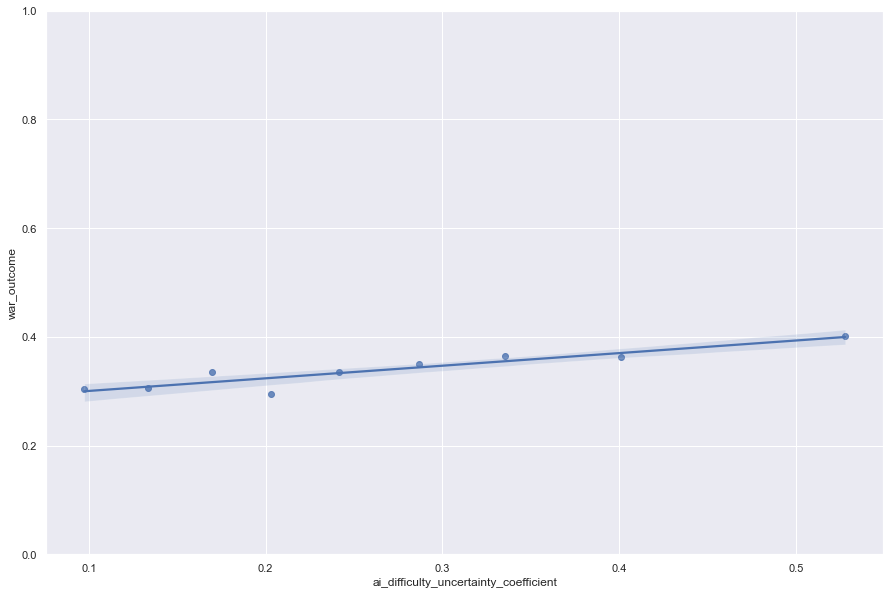

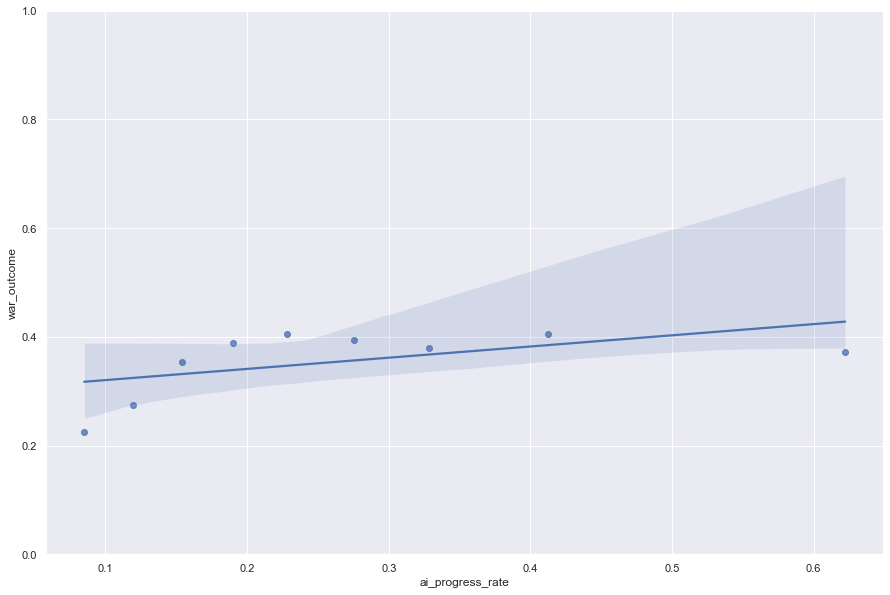

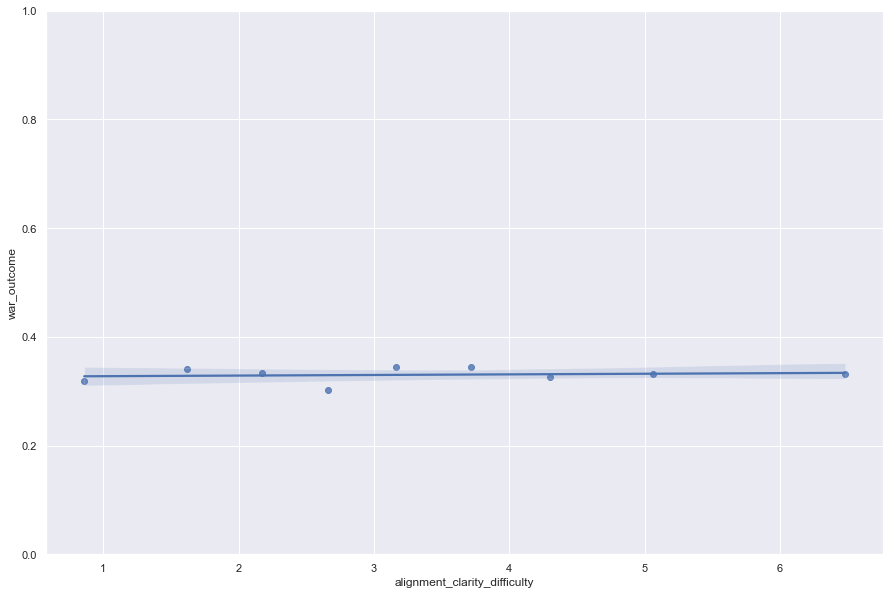

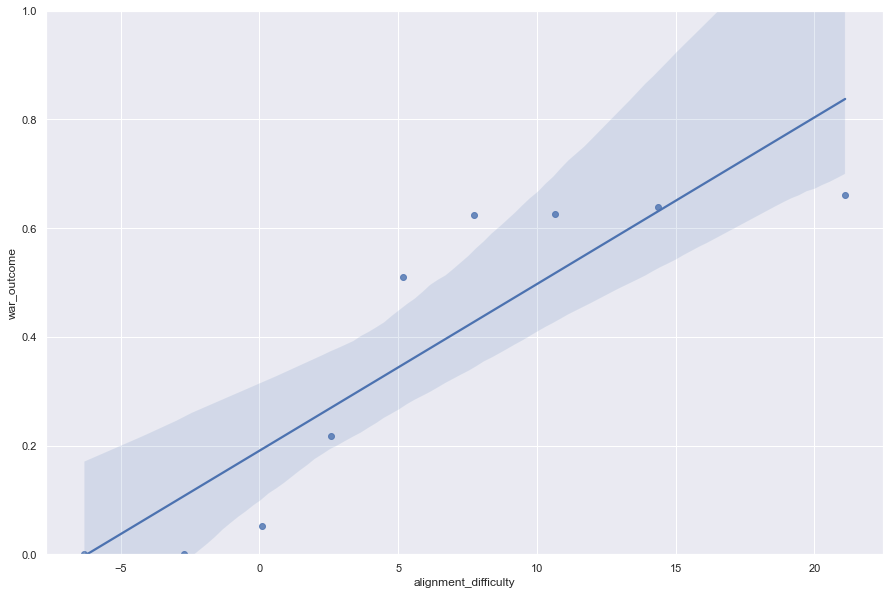

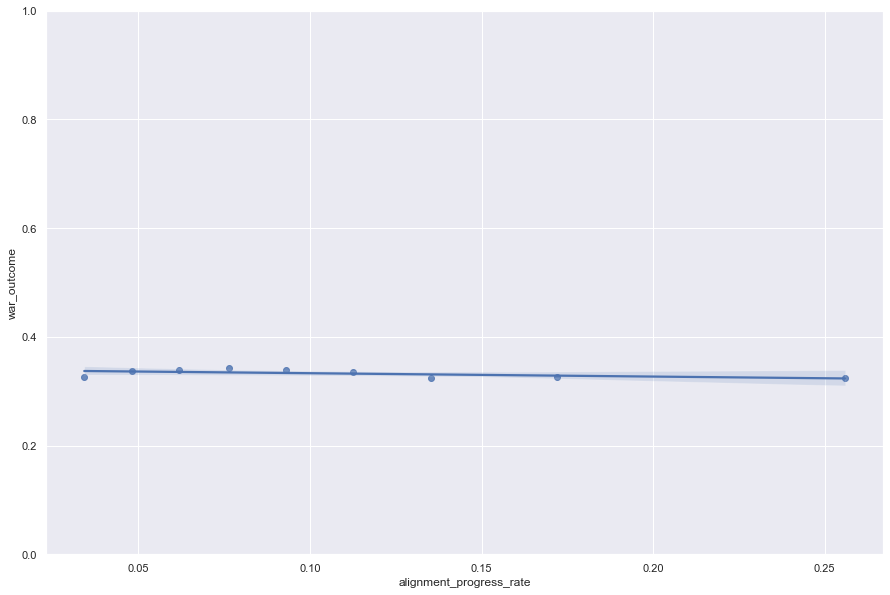

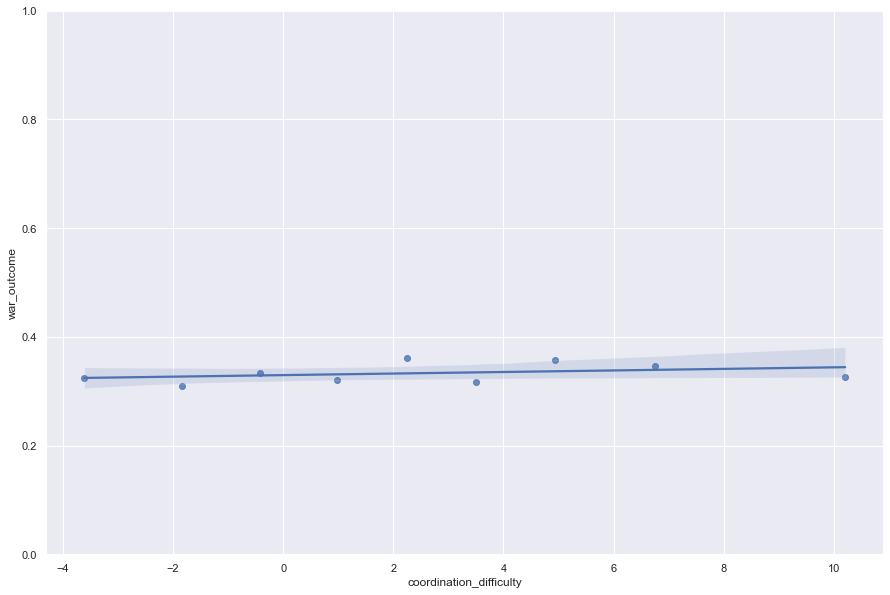

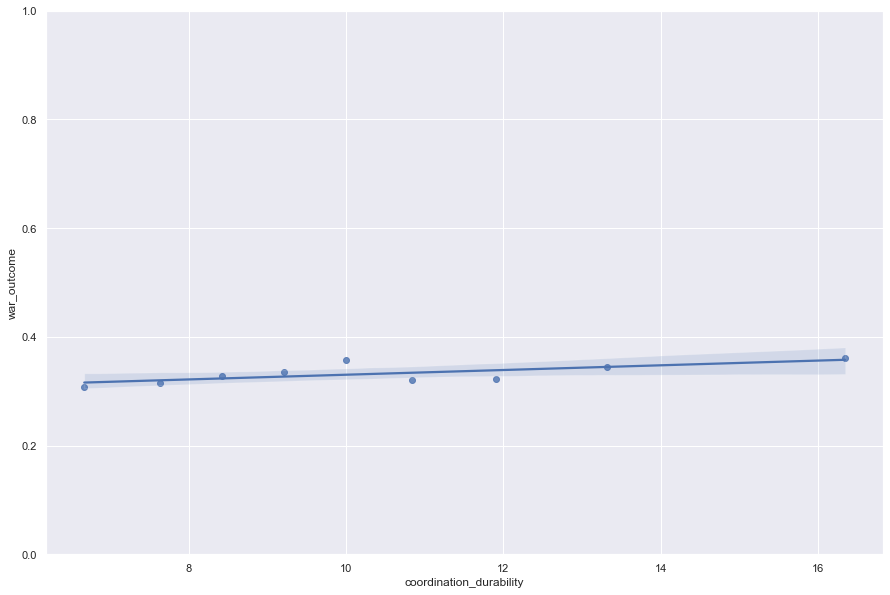

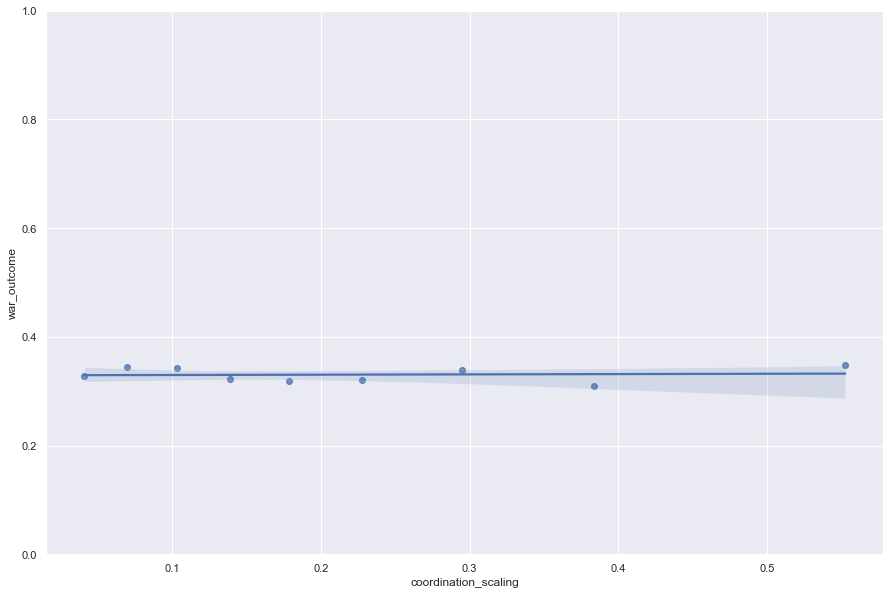

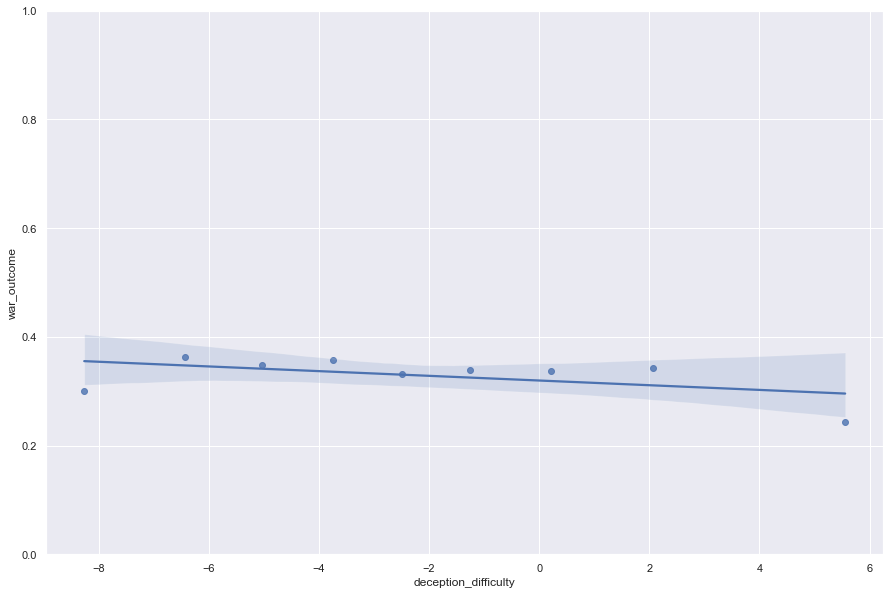

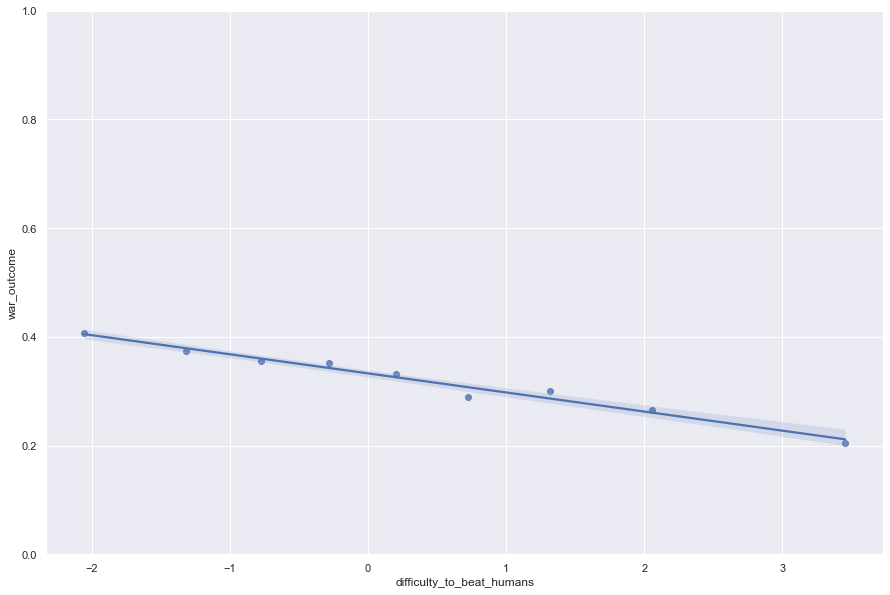

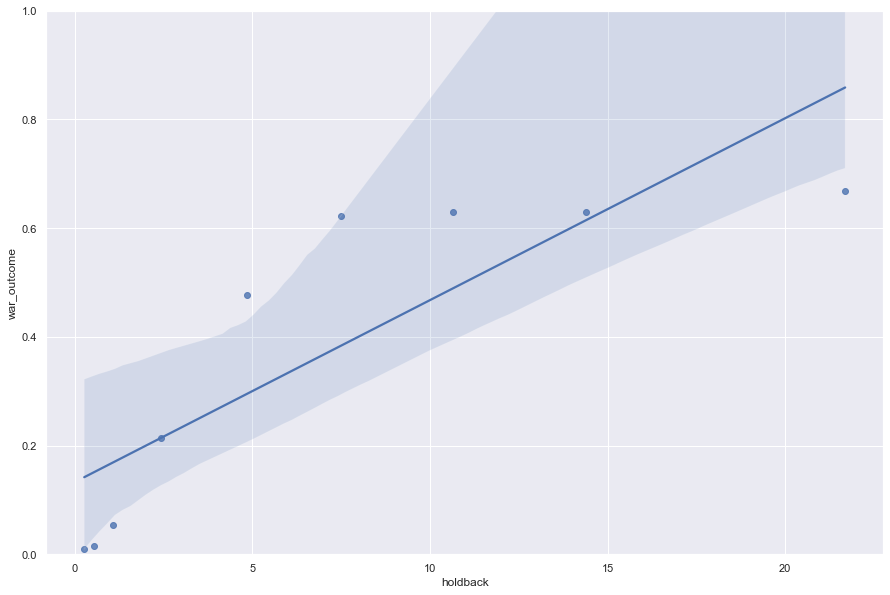

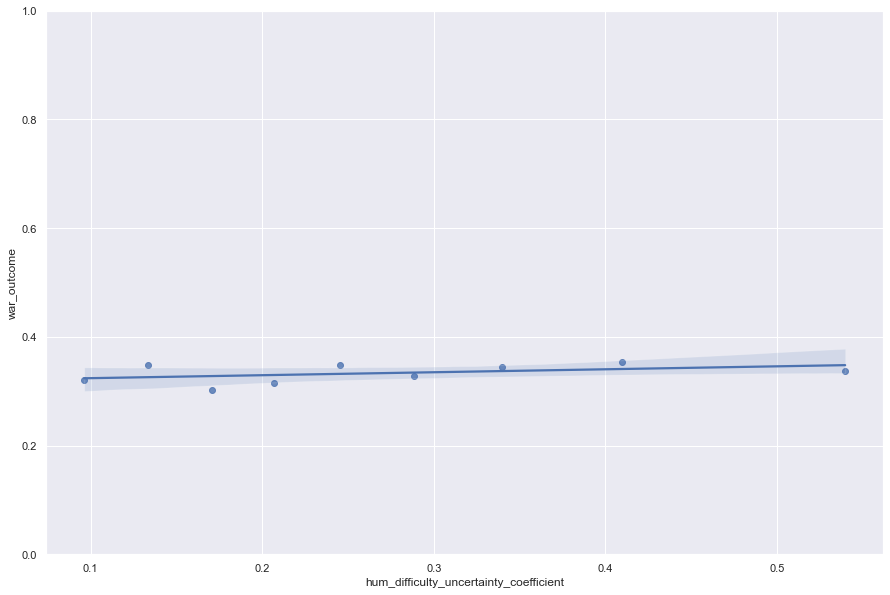

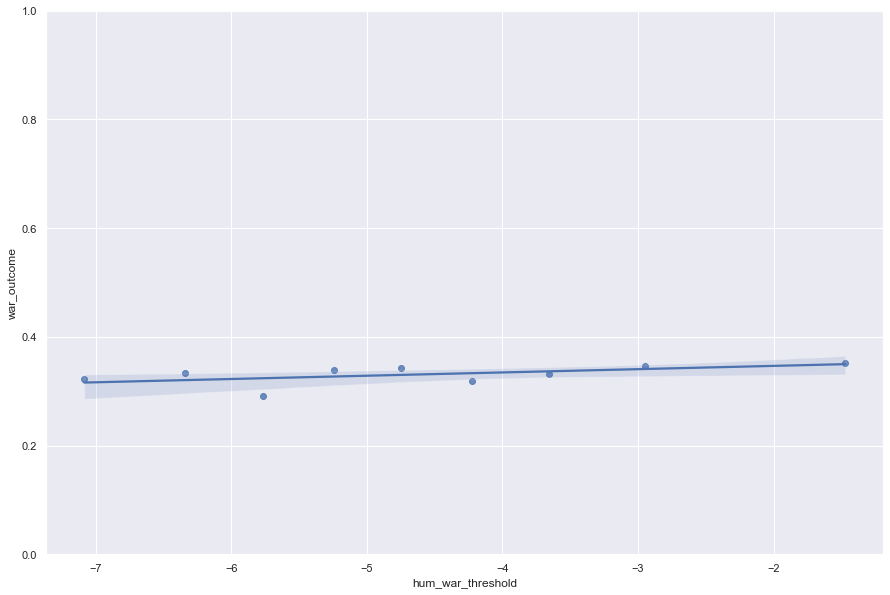

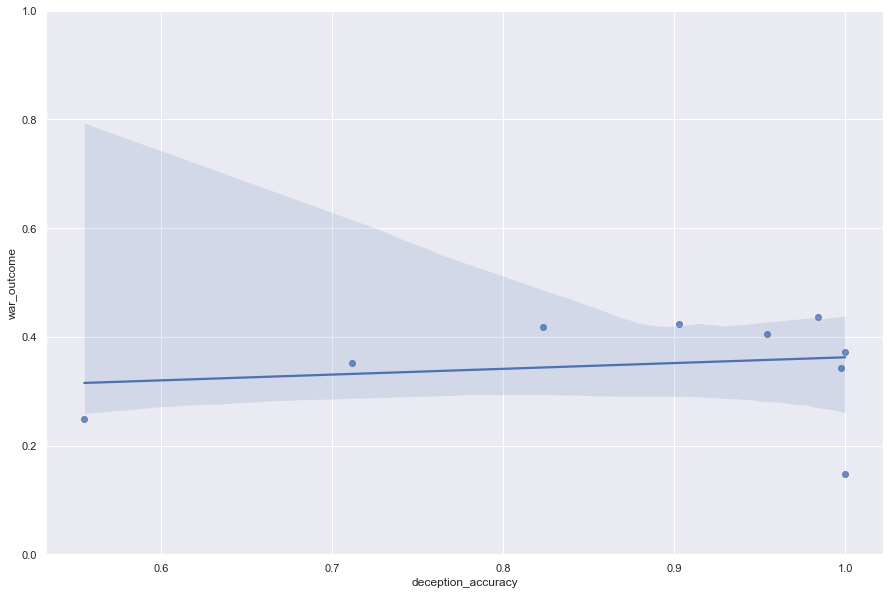

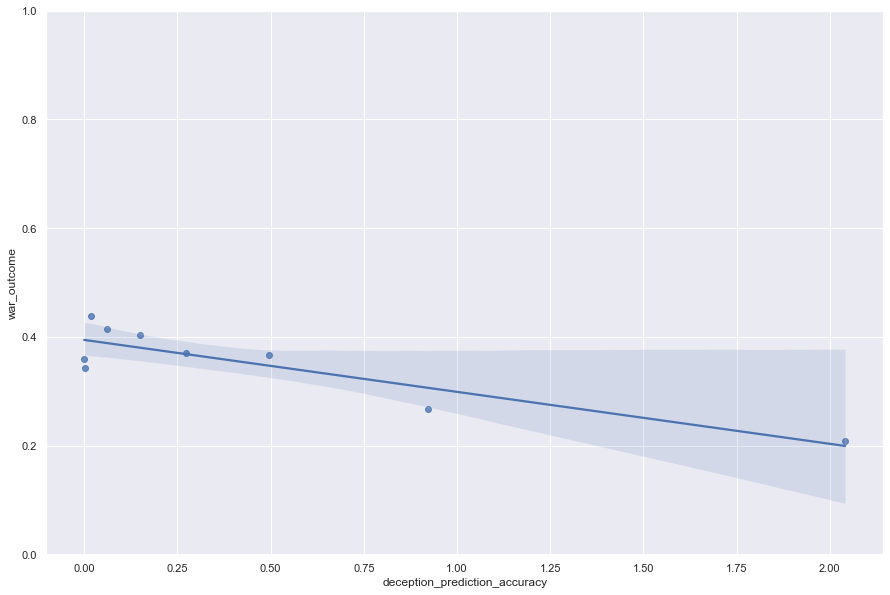

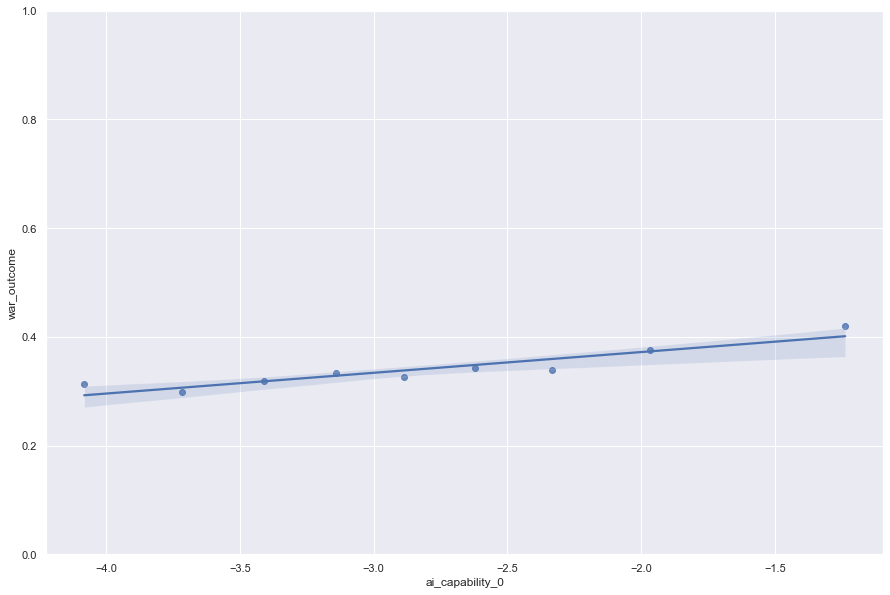

In [257]:
for k in keys_to_check:
    if ('ever' in k) or (k in ['war_outcome', 'war_breakout']):
        continue
    print(k)
    quantiles = np.quantile(data[k], np.linspace(0.1,1,10))
    cuts = pd.cut(data[k],quantiles)
    df = data.groupby(cuts)[['war_outcome',k]].mean().reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.regplot(data = df, y='war_outcome', x=k, ax=ax)
    ax.set_ylim([0,1])

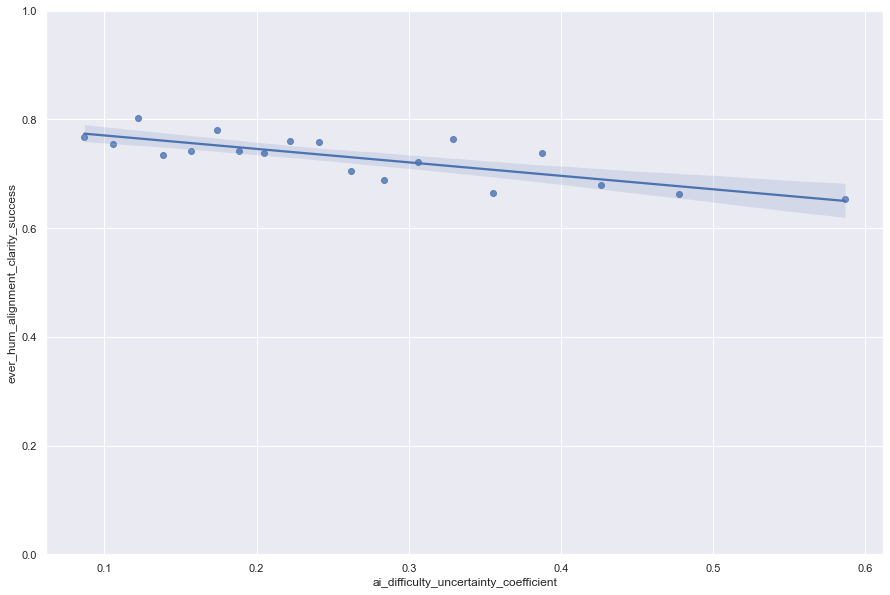

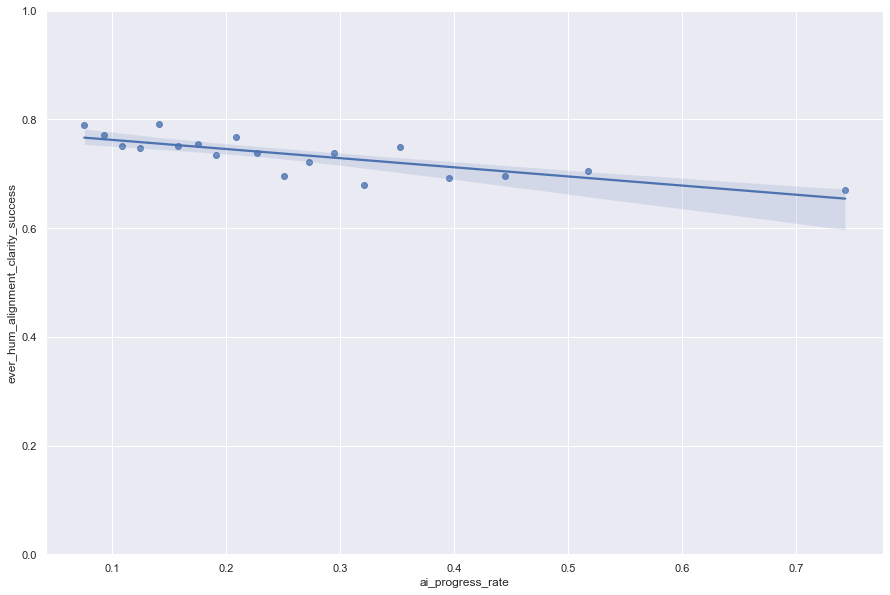

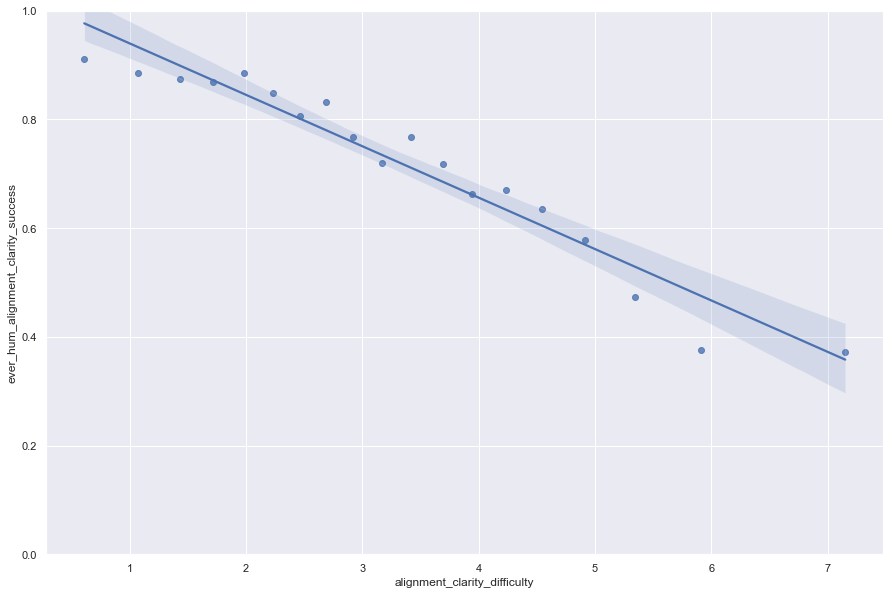

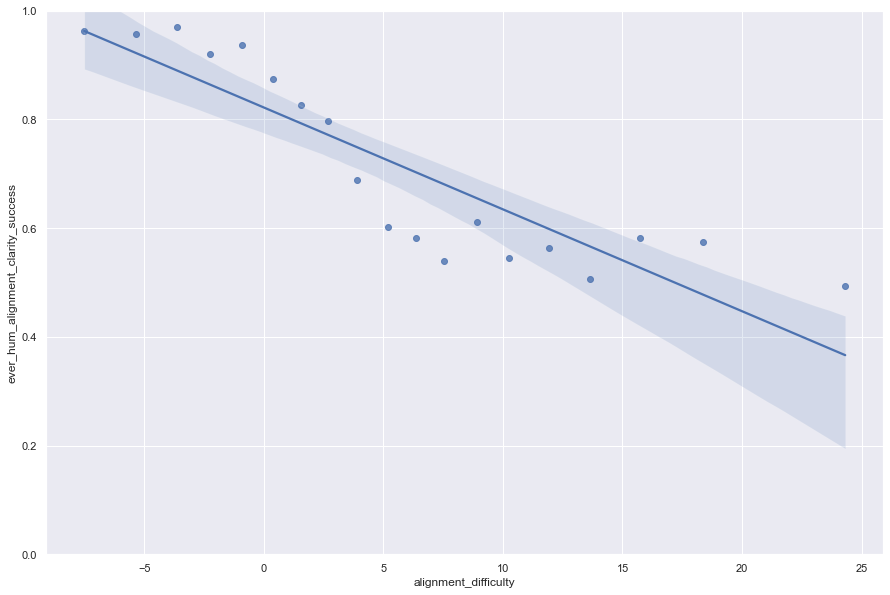

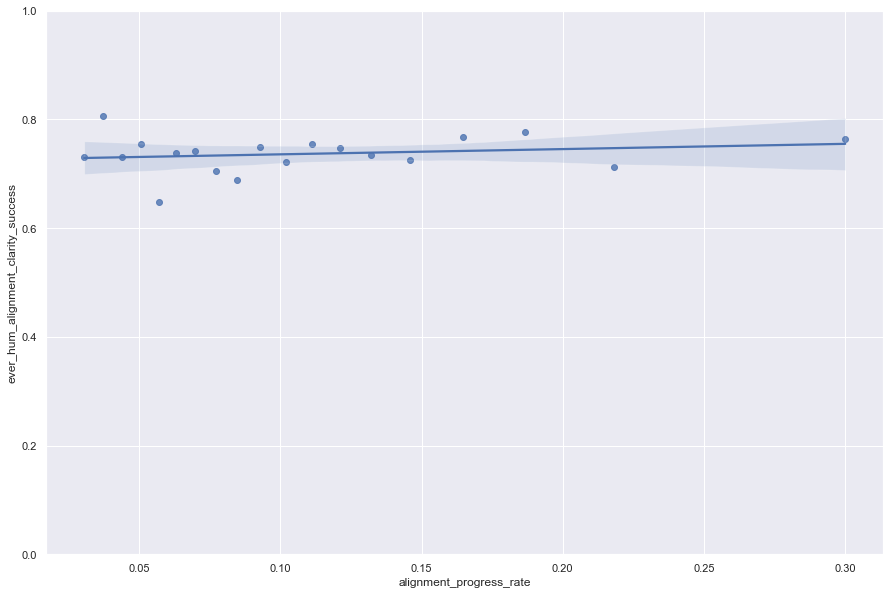

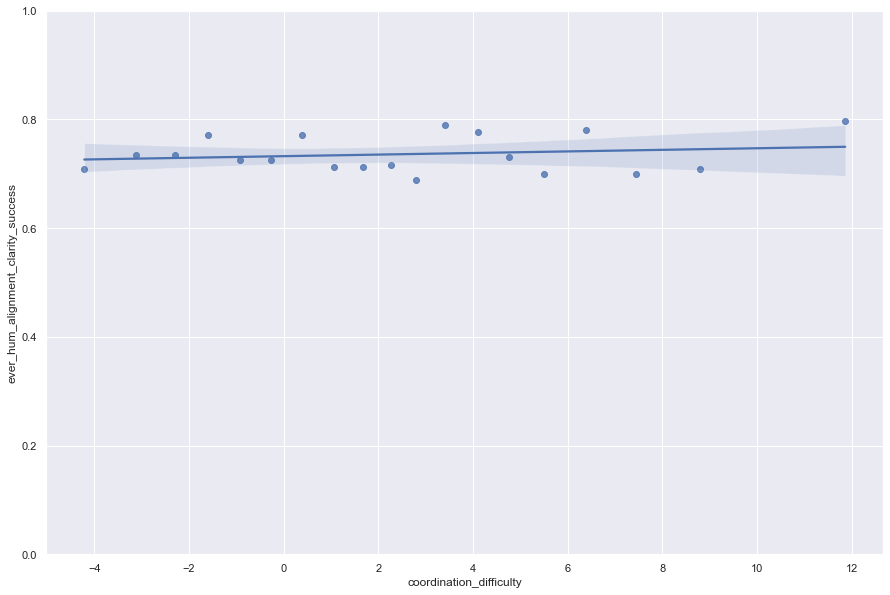

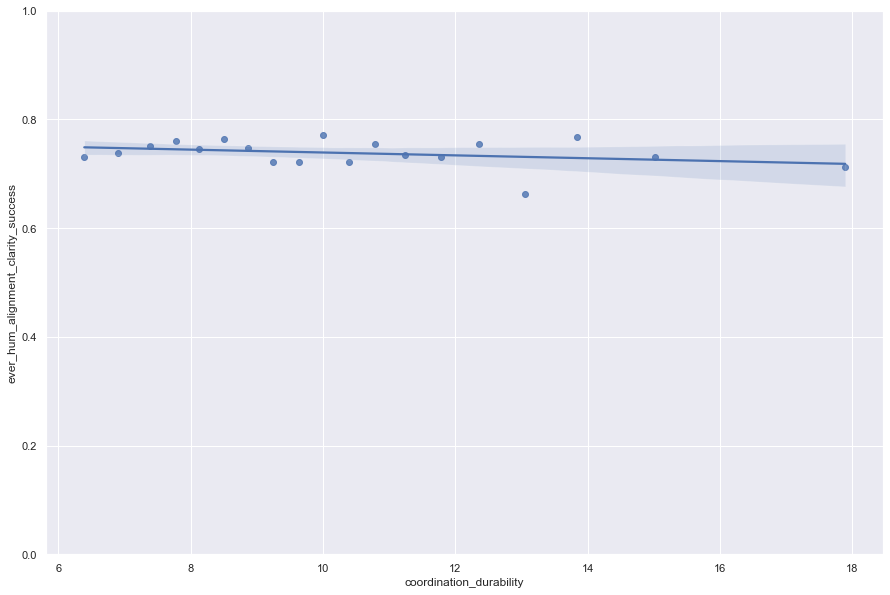

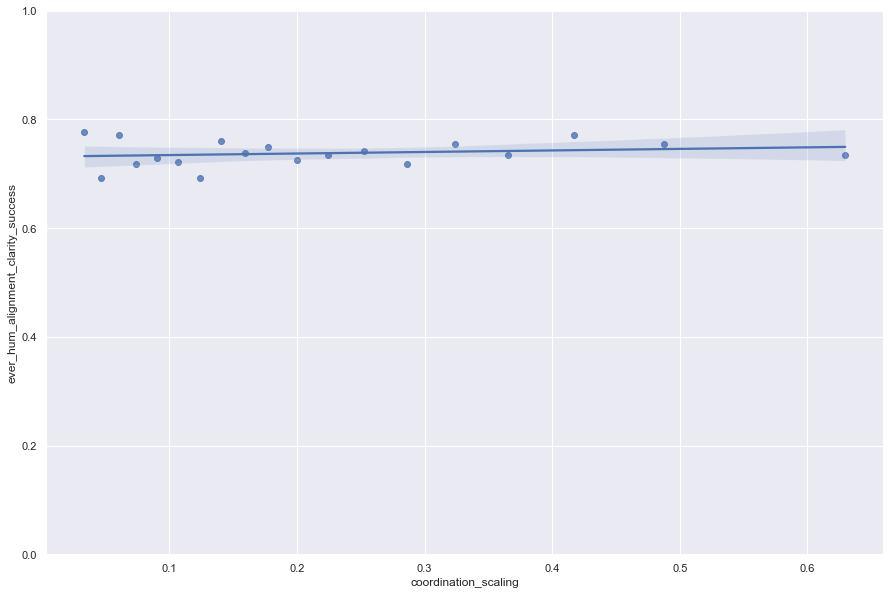

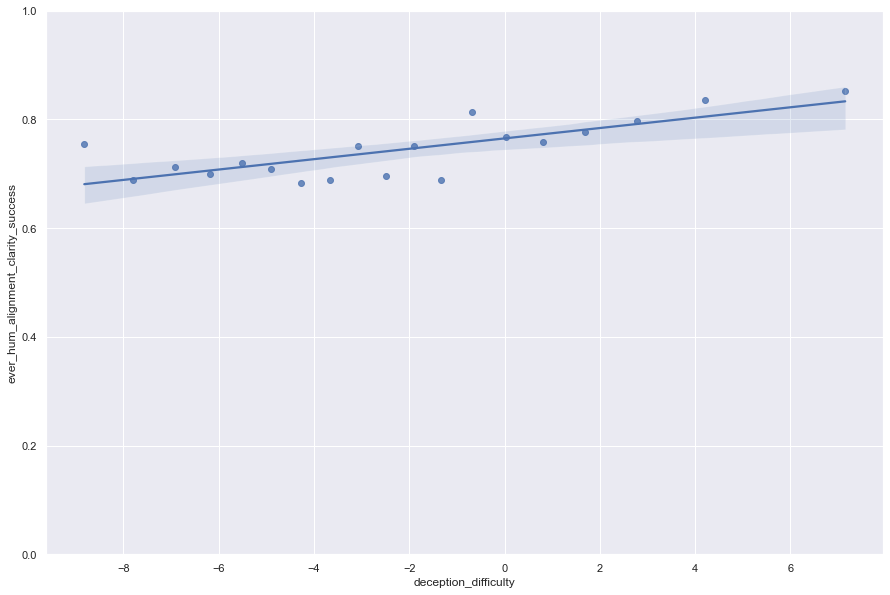

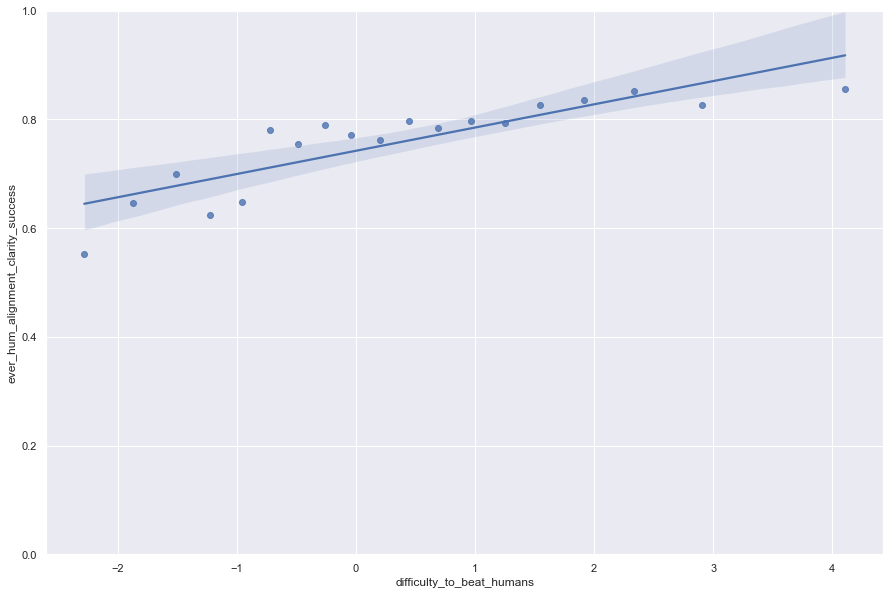

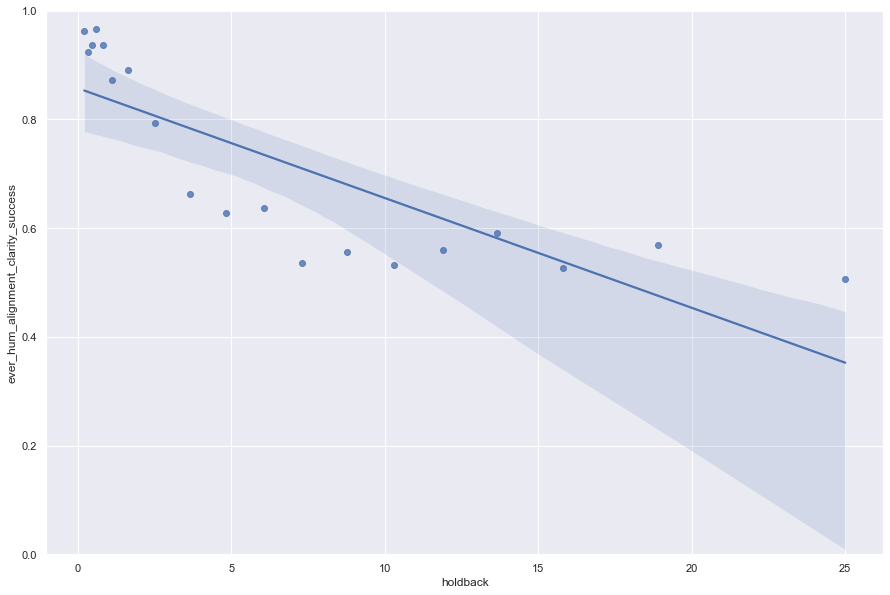

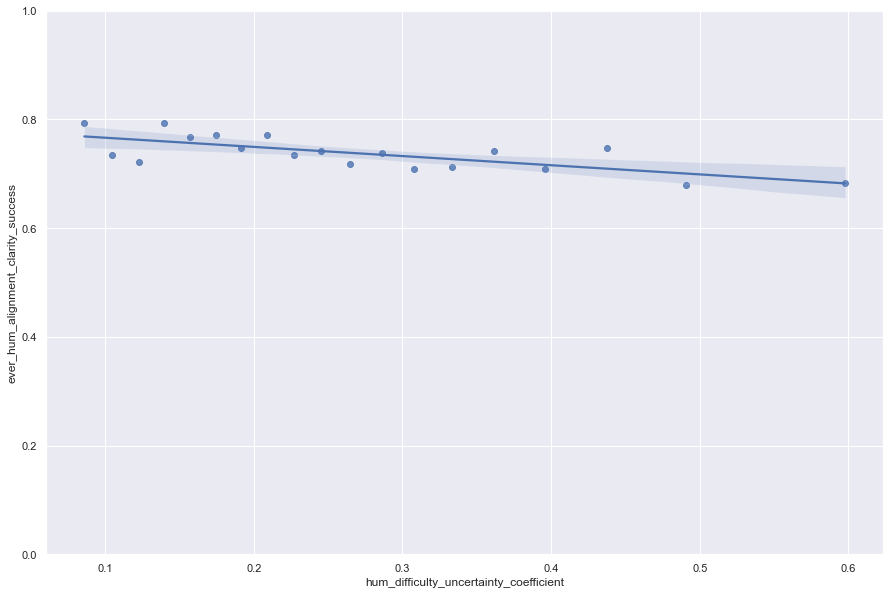

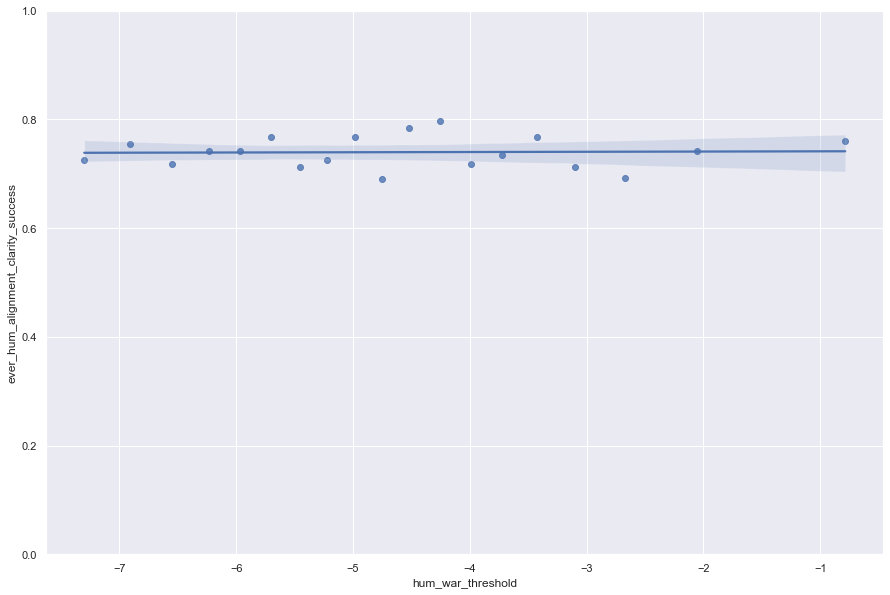

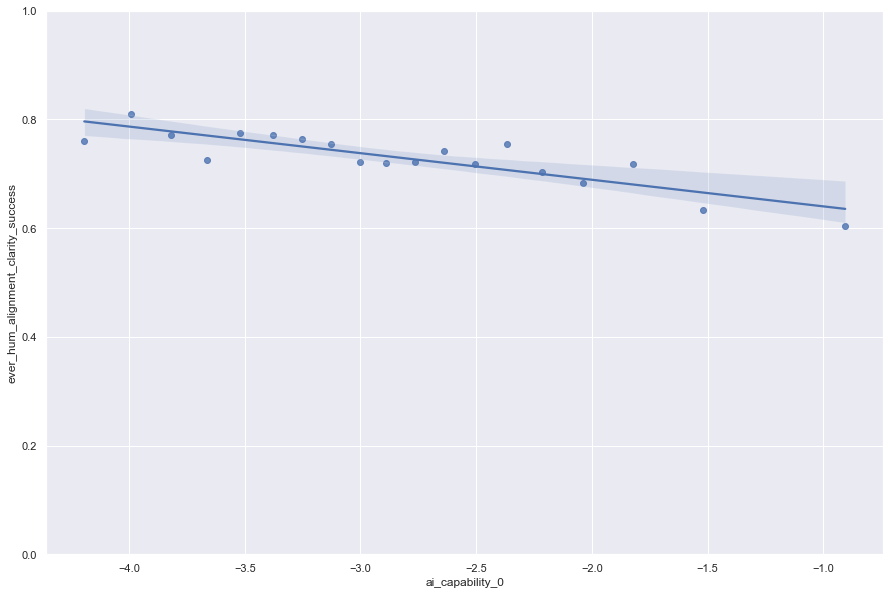

In [156]:
for k in keys_to_check:
    if ('ever' in k) or (k in ['war_outcome', 'war_breakout']):
        continue
    quantiles = np.quantile(data[k], np.linspace(0.1,1,20))
    cuts = pd.cut(data[k],quantiles)
    df = data.groupby(cuts)[['ever_hum_alignment_clarity_success',k]].mean().reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.regplot(data = df, y='ever_hum_alignment_clarity_success', x=k, ax=ax)
    ax.set_ylim([0,1])

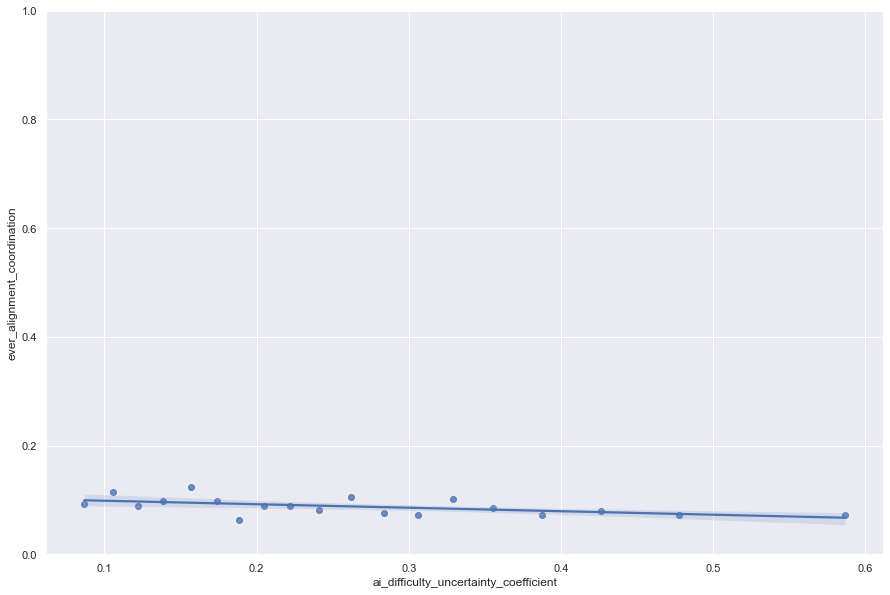

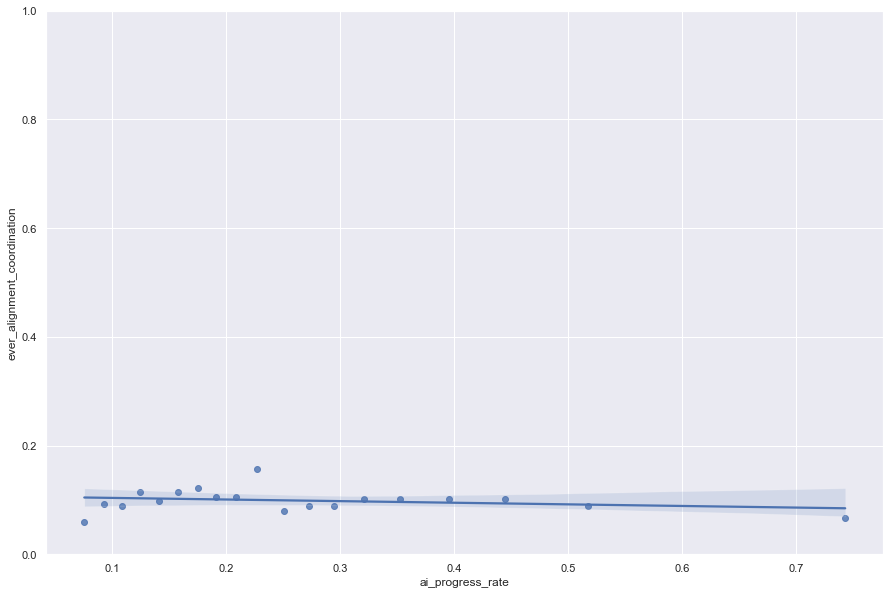

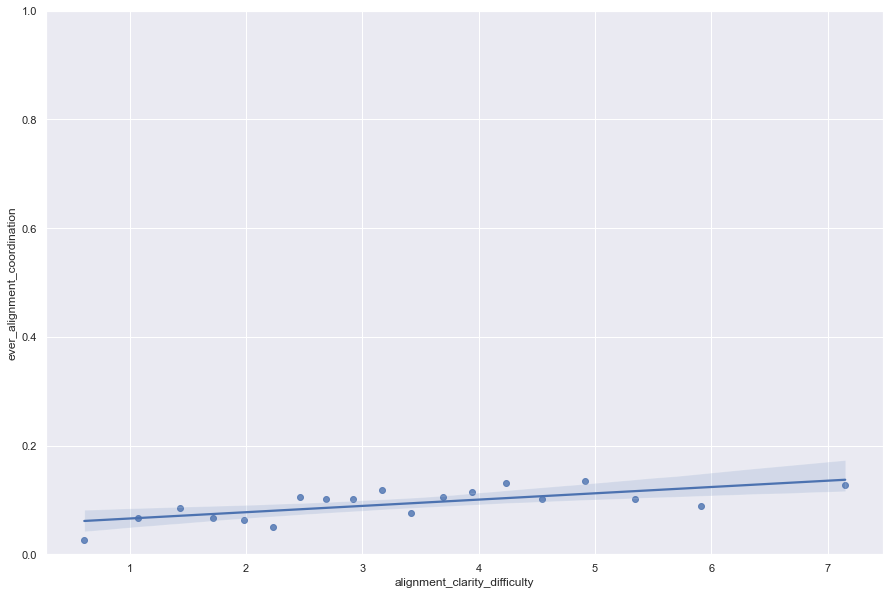

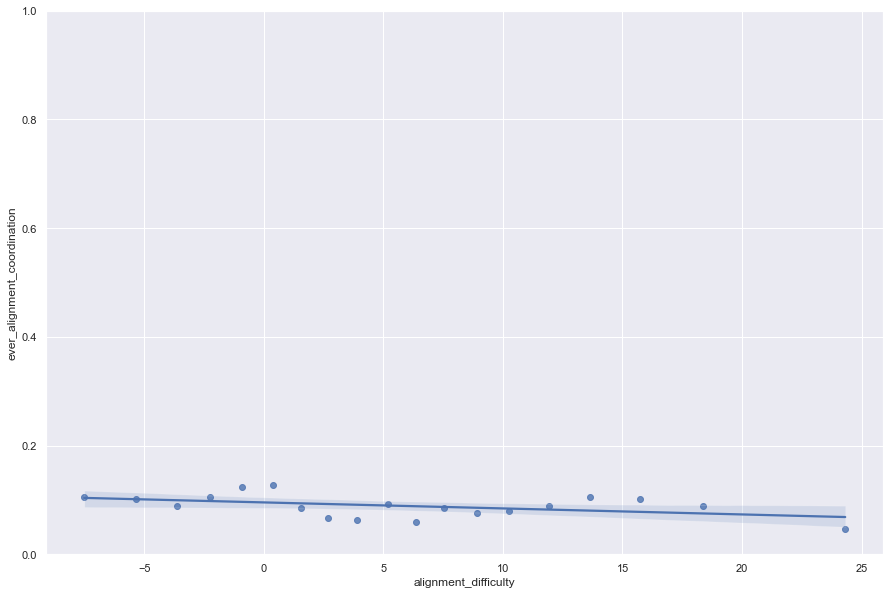

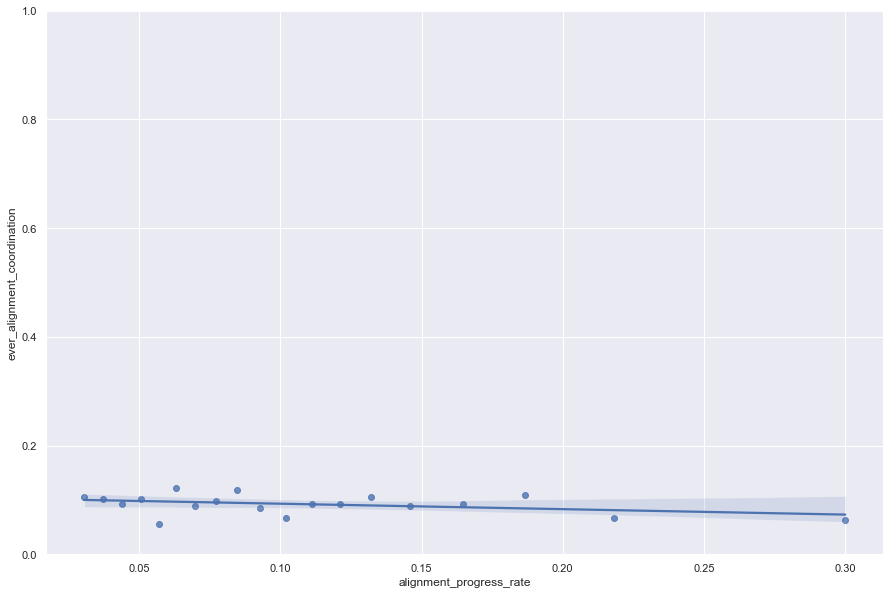

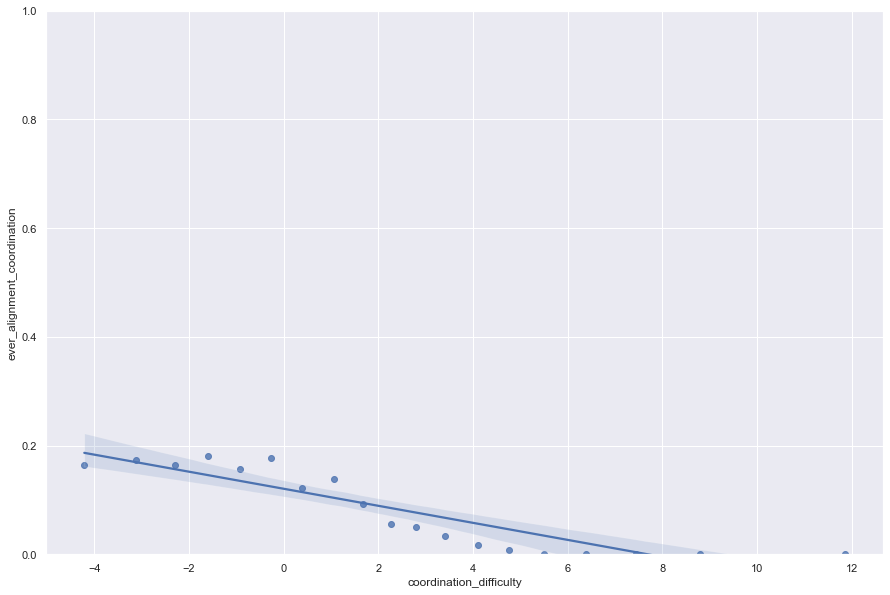

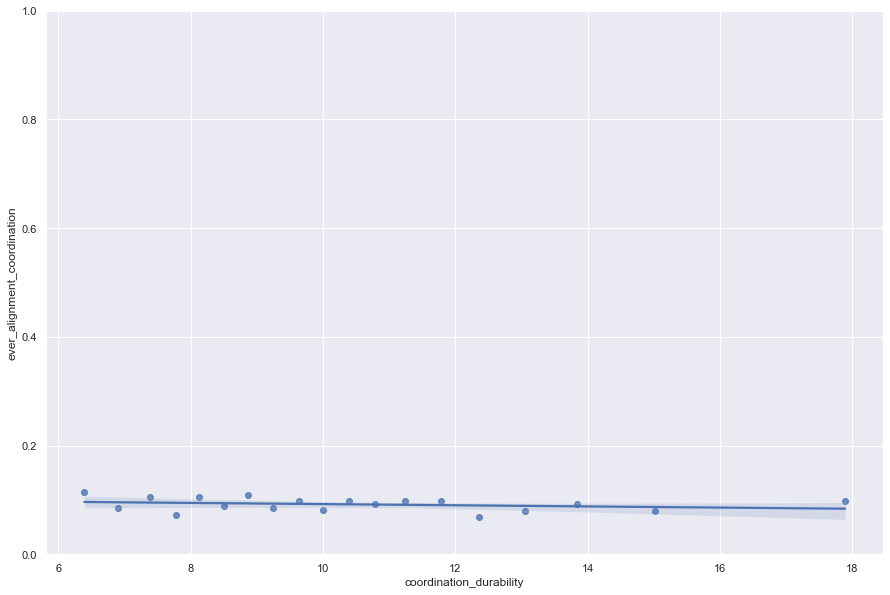

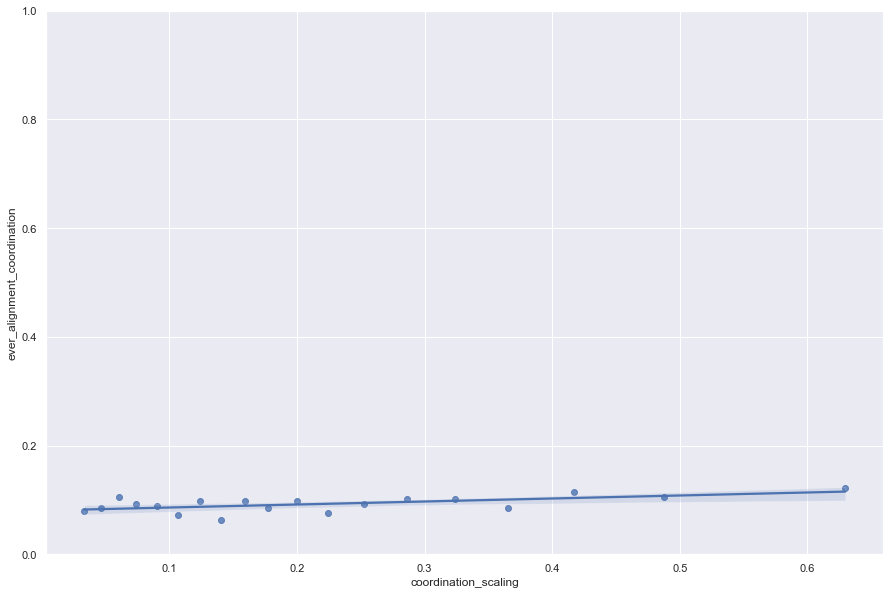

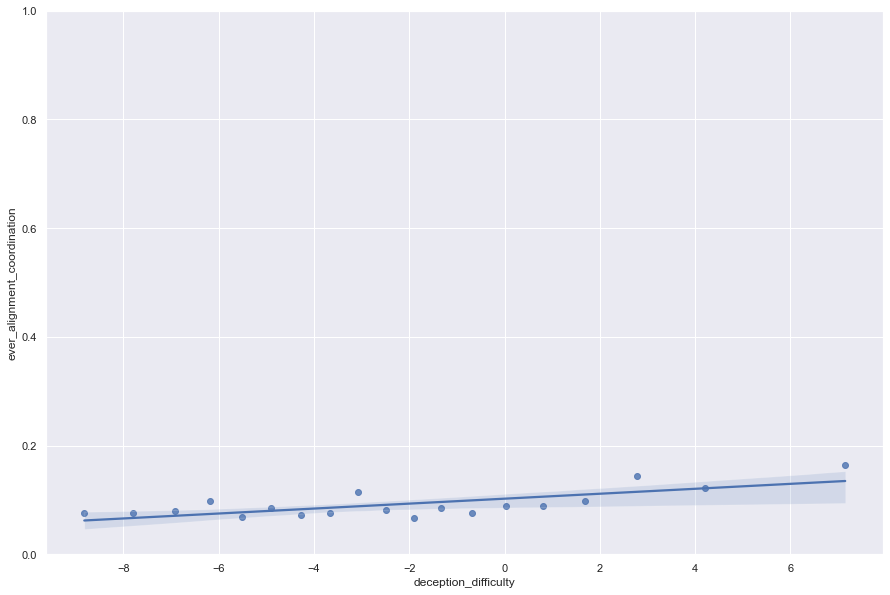

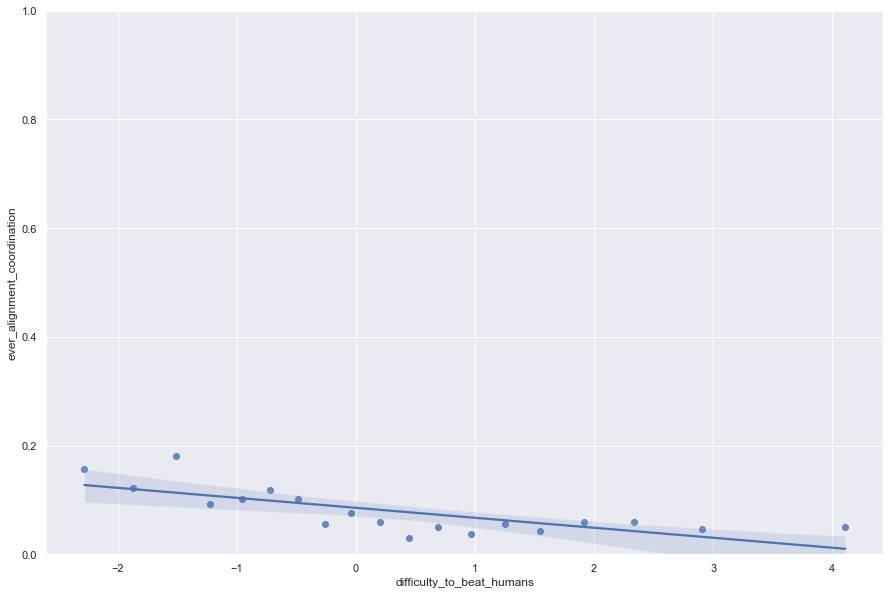

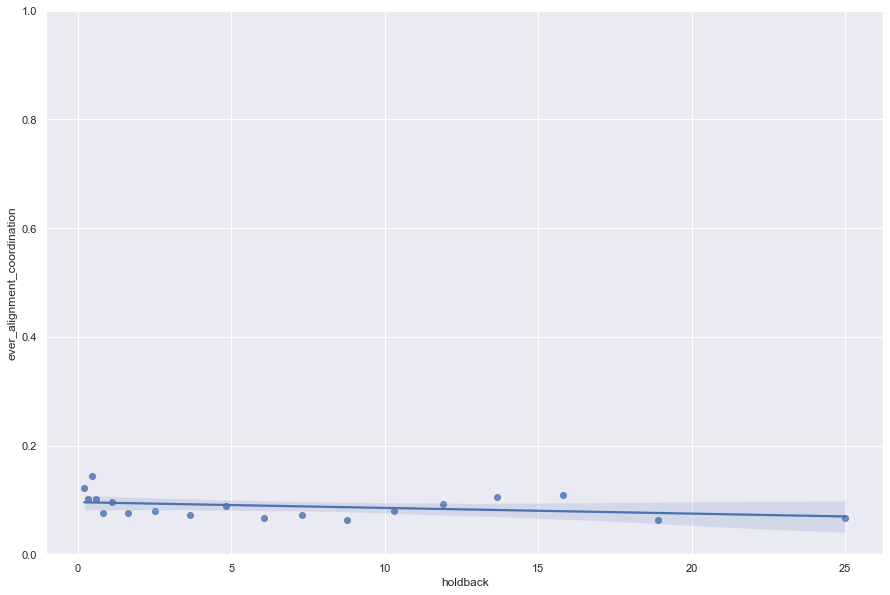

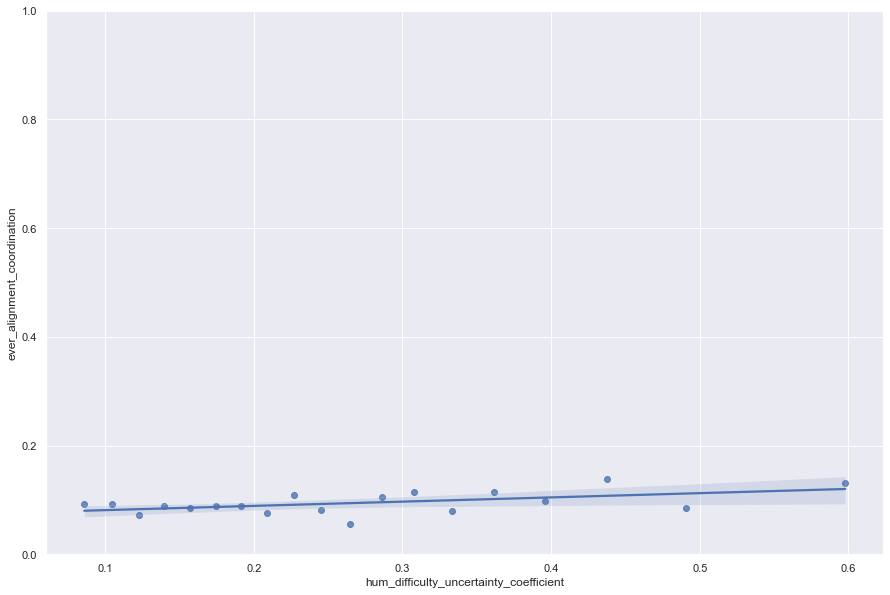

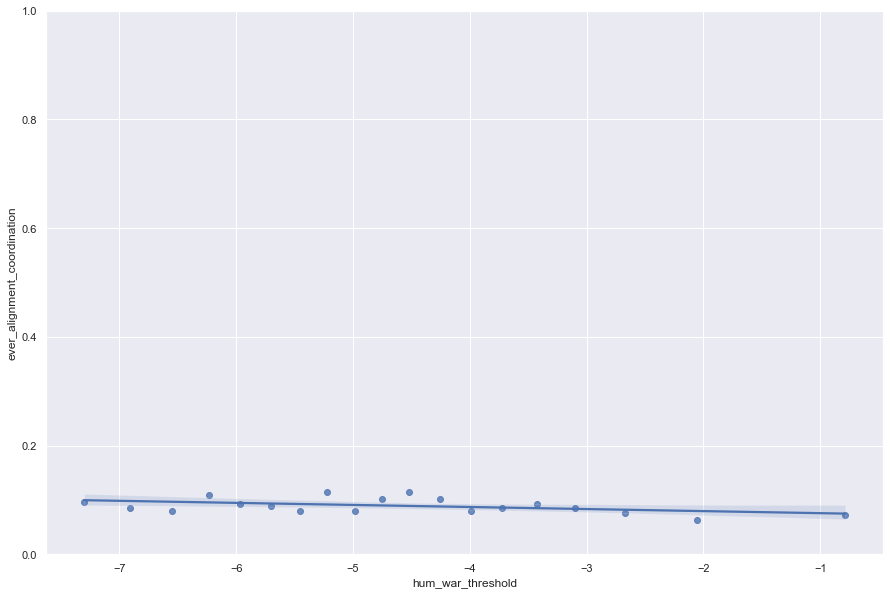

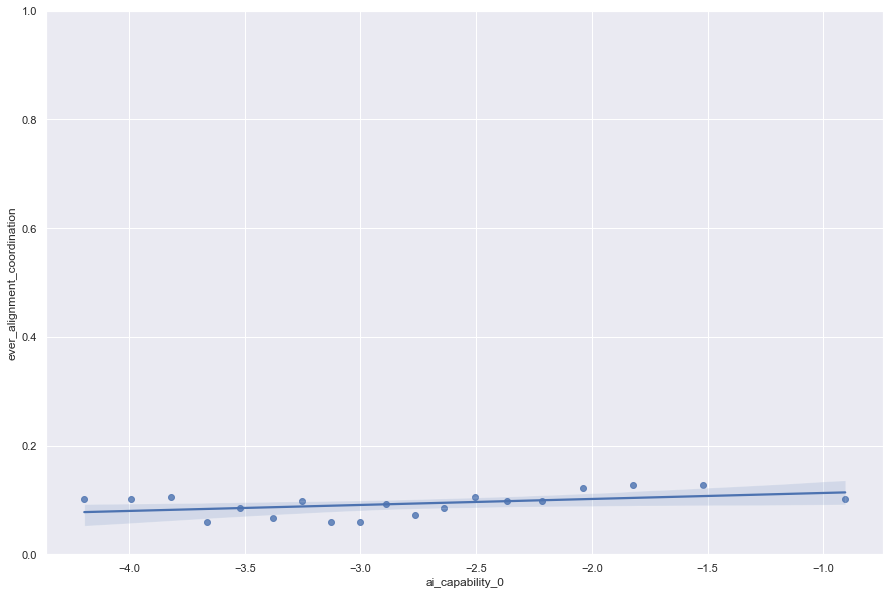

In [173]:
for k in keys_to_check:
    if ('ever' in k) or (k in ['war_outcome', 'war_breakout']):
        continue
    quantiles = np.quantile(data[k], np.linspace(0.1,1,20))
    cuts = pd.cut(data[k],quantiles)
    df = data.groupby(cuts)[['ever_alignment_coordination',k]].mean().reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.regplot(data = df, y='ever_alignment_coordination', x=k, ax=ax)
    ax.set_ylim([0,1])